## Installing and Importing Required Libraries

In [ ]:
!pip install -q yfinance
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langgraph
!pip install langchain_huggingface
!pip install tabulate
!pip uninstall -y pydantic
!pip install --no-cache-dir "pydantic>=2.11,<3"


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Found existing installation: pydantic 2.11.7
Uninstalling pydantic-2.11.7:
  Successfully uninstalled pydantic-2.11.7
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 KB 669.3 kB/s eta 0:00:001m711.9 kB/s eta 0:00:01


In [ ]:
import yfinance as yf
import pandas as pd
import json
import datetime as dt
import base64
import requests
import numpy as np

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import OpenAI
from langchain.agents.agent_types import AgentType
from typing_extensions import List, TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display

## Inserting and Retrieving Stock Market Data from GridDB

### Importing Stock Market Data From Yahoo Finance

In [ ]:
import yfinance as yf
import pandas as pd

ticker      = "AAPL"
start_date  = "2024-01-01"
end_date    = "2024-12-31"

dataset = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# ───────────────────────────────────────────────────────────────
# 1.  FLATTEN: keep the level that holds 'Close', 'High', …
# ───────────────────────────────────────────────────────────────
if isinstance(dataset.columns, pd.MultiIndex):

    # find the level index where 'Close' lives
    for lvl in range(dataset.columns.nlevels):
        level_vals = dataset.columns.get_level_values(lvl)
        if 'Close' in level_vals:
            dataset.columns = level_vals        # keep that level
            break
else:
    # already flat – nothing to do
    pass

# ───────────────────────────────────────────────────────────────
# 2.  Select OHLCV, move index to 'Date'
# ───────────────────────────────────────────────────────────────
dataset = dataset[['Close', 'High', 'Low', 'Open', 'Volume']]
dataset = dataset.reset_index().rename(columns={'index': 'Date'})
dataset['Date'] = pd.to_datetime(dataset['Date'])

# optional: reorder columns
dataset = dataset[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
dataset.columns.name = None

dataset.head()


[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2024-01-02,185.639999,188.440002,183.889999,187.149994,82488700
1,2024-01-03,184.250000,185.880005,183.429993,184.220001,58414500
2,2024-01-04,181.910004,183.089996,180.880005,182.149994,71983600
3,2024-01-05,181.179993,182.759995,180.169998,181.990005,62303300
4,2024-01-08,185.559998,185.600006,181.500000,182.089996,59144500


### Establishing a Connection with GridDB Cloud

In [ ]:
username = "your_user_name"
password = "your_password"
base_url = "your_griddb_host_url"

url = f"{base_url}/checkConnection"

credentials = f"{username}:{password}"
encoded_credentials = base64.b64encode(credentials.encode()).decode()

headers = {
    'Content-Type': 'application/json',  # Added this header to specify JSON content
    'Authorization': f'Basic {encoded_credentials}',
    'User-Agent': 'PostmanRuntime/7.29.0'
}

response = requests.get(url, headers=headers)

print(response.status_code)
print(response.text)

200



### Creating Container for Inserting Stock Market Data in GridDB Cloud

In [ ]:
dataset.insert(0, "SerialNo", dataset.index + 1)
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.strftime('%Y-%m-%d')  # "2024-01-02"
dataset.columns.name = None
# Mapping pandas dtypes to GridDB types
type_mapping = {
    "int64":          "LONG",
    "float64":        "DOUBLE",
    "bool":           "BOOL",
    'datetime64': "TIMESTAMP",
    "object":         "STRING",
    "category":       "STRING",
}

# Generate the columns part of the payload dynamically
columns = []
for col, dtype in dataset.dtypes.items():
    griddb_type = type_mapping.get(str(dtype), "STRING")  # Default to STRING if unknown
    columns.append({
        "name": col,
        "type": griddb_type
    })

columns

[{'name': 'SerialNo', 'type': 'LONG'},
 {'name': 'Date', 'type': 'STRING'},
 {'name': 'Close', 'type': 'DOUBLE'},
 {'name': 'High', 'type': 'DOUBLE'},
 {'name': 'Low', 'type': 'DOUBLE'},
 {'name': 'Open', 'type': 'DOUBLE'},
 {'name': 'Volume', 'type': 'LONG'}]

In [ ]:
url = f"{base_url}/containers"
container_name = "stock_db"
# Create the payload for the POST request
payload = json.dumps({
    "container_name": container_name,
    "container_type": "COLLECTION",
    "rowkey": True,  # Assuming the first column as rowkey
    "columns": columns
})


# Make the POST request to create the container
response = requests.post(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")


Status Code: 201


### Adding Stock Data to GridbDB Cloud Container

In [ ]:
url = f"{base_url}/containers/{container_name}/rows"
# Convert dataset to list of lists (row-wise) with proper formatting

def format_row(row):
    formatted = []
    for item in row:
        if pd.isna(item):
            formatted.append(None)  # Convert NaN to None
        elif isinstance(item, bool):
            formatted.append(str(item).lower())  # Convert True/False to true/false
        elif isinstance(item, (int, float)):
            formatted.append(item)  # Keep integers and floats as they are
        else:
            formatted.append(str(item))  # Convert other types to string
    return formatted

# Prepare rows with correct formatting
rows = [format_row(row) for row in dataset.values.tolist()]

# Create payload as a JSON string
payload = json.dumps(rows)

# Make the PUT request to add the rows to the container
response = requests.put(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")
print(f"Response Text: {response.text}")


Status Code: 200
Response Text: {"count":251}


### Retrieving Data from GridDB

In [ ]:
container_name = "stock_db"

url = f"{base_url}/containers/{container_name}/rows"

# Define the payload for the query
payload = json.dumps({
    "offset": 0,           # Start from the first row
    "limit": 10000,         # Limit the number of rows returned
    "condition": "",       # No filtering condition (you can customize it)
    "sort": ""             # No sorting (you can customize it)
})

# Make the POST request to read data from the container
response = requests.post(url, headers=headers, data=payload)

# Check response status and print output
print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    try:
        data = response.json()
        print("Data retrieved successfully!")

        # Convert the response to a DataFrame
        rows = data.get("rows", [])
        stock_dataset = pd.DataFrame(rows, columns=[col for col in dataset.columns])

    except json.JSONDecodeError:
        print("Error: Failed to decode JSON response.")
else:
    print(f"Error: Failed to query data from the container. Response: {response.text}")

print(stock_dataset.shape)
stock_dataset.head()

Status Code: 200
Data retrieved successfully!
(251, 7)


,SerialNo,Date,Close,High,Low,Open,Volume
0,1,2024-01-02,185.639999,188.440002,183.889999,187.149994,82488700
1,2,2024-01-03,184.250000,185.880005,183.429993,184.220001,58414500
2,3,2024-01-04,181.910004,183.089996,180.880005,182.149994,71983600
3,4,2024-01-05,181.179993,182.759995,180.169998,181.990005,62303300
4,5,2024-01-08,185.559998,185.600006,181.500000,182.089996,59144500


## Creating a Stock Market ChatBot Using GridDB Data

## Creating a Graph in LangGraph

In [ ]:
class State(TypedDict):
    question: str
    answer: str

In [ ]:
api_key = "YOUR_OPENAI_API_KEY"
llm = ChatOpenAI(model = 'gpt-4o',
                api_key = api_key)

agent = create_pandas_dataframe_agent(llm,
                                      stock_dataset,
                                      verbose=True,
                                      agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                                      allow_dangerous_code=True)

def run_llm(state: State):
    question = state['question']
    response = agent.invoke(question)
    return {'answer': response['output']}

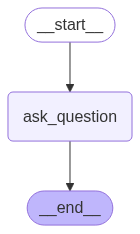

In [ ]:
graph_builder=StateGraph(State)
graph_builder.add_node("ask_question", run_llm)
graph_builder.add_edge(START,"ask_question")
graph_builder.add_edge("ask_question",END)
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
question = [HumanMessage(content="Which month had the highest average opening stock price? And what is the month where people made most profit in day trading?")]
result = graph.invoke({"question": question})
print(result['answer'])



> Entering new AgentExecutor chain...
Thought: To determine which month had the highest average opening stock price, we need to group the data by month and calculate the average opening price for each month. For the month where people made the most profit in day trading, we can calculate daily profit as the difference between the high and low prices, then aggregate these by month to find the month with the highest total daily profit. Let's proceed with these calculations.
Action: python_repl_ast
Action Input: 
```python
import pandas as pd

# Convert the 'Date' column to datetime format to extract month information
df['Date'] = pd.to_datetime(df['Date'])

# Extract month and year for grouping
df['YearMonth'] = df['Date'].dt.to_period('M')

# Calculate average opening stock price for each month
average_opening_by_month = df.groupby('YearMonth')['Open'].mean()

# Calculate daily profit (difference between 'High' and 'Low')
df['DailyProfit'] = df['High'] - df['Low']

# Calculate total d



> Entering new AgentExecutor chain...
Thought: To identify interesting patterns in the dataset, I can perform a few basic analyses, such as checking for trends, patterns, or correlations in the data. I can look for trends over time in the stock prices or volume, check for correlations between columns, or observe any patterns in daily trading behavior. I will start by calculating some descriptive statistics and visualizing the data to identify any patterns.

Action: python_repl_ast
Action Input: 
"""
import pandas as pd
import matplotlib.pyplot as plt

# Describe the dataframe to get an overview of its statistics.
df_description = df.describe()

# Plotting the Close prices over time to check for trends.
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_description
"""

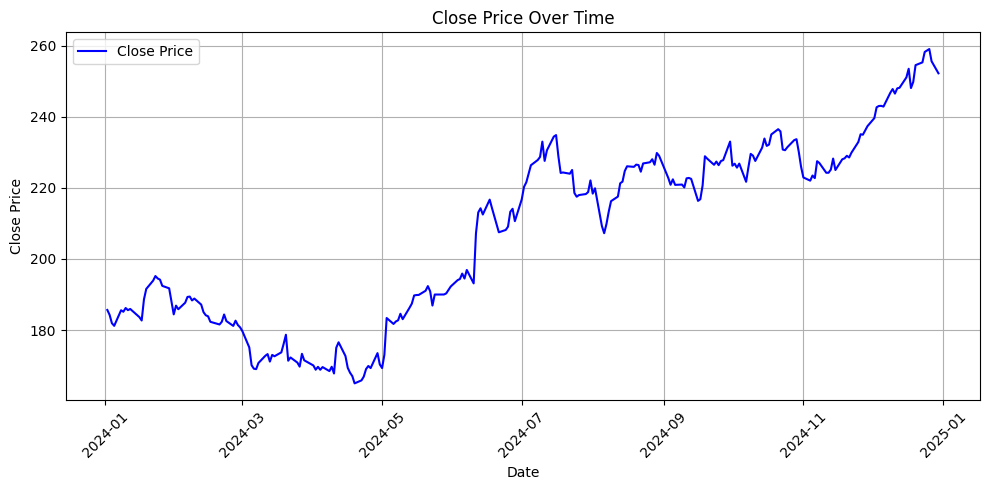

         SerialNo                           Date       Close        High  \
count  251.000000                            251  251.000000  251.000000   
mean   126.000000  2024-07-01 02:11:57.131474176  207.033745  208.733546   
min      1.000000            2024-01-02 00:00:00  165.000000  166.399994   
25%     63.500000            2024-04-02 12:00:00  184.199997  185.119995   
50%    126.000000            2024-07-02 00:00:00  214.240005  216.779999   
75%    188.500000            2024-09-30 12:00:00  227.424995  229.375000   
max    251.000000            2024-12-30 00:00:00  259.019989  260.100006   
std     72.601653                            NaN   25.406784   25.477327   

              Low        Open        Volume  DailyProfit  
count  251.000000  251.000000  2.510000e+02   251.000000  
mean   205.040279  206.771115  5.719756e+07     3.693267  
min    164.080002  165.350006  2.323470e+07     0.959991  
25%    182.180000  183.735001  4.187125e+07     2.480003  
50%    211.919998  2

In [ ]:
question = [HumanMessage(content="Do you find any interesting patterns in the dataset?")]
result = graph.invoke({"question": question})
print(result['answer'])